# Синтетическая демонстрация ALS-рекомендаций  
Генерация случайных взаимодействий, обучение ALS, оценка Precision/Recall/F1 и визуализация результатов.


Сгенерировано взаимодействий: 24970
train_matrix.shape: (800, 500)


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.004602670669555664 seconds
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

Обучение завершено.
Пользователей в оценке: 200
Precision@K: [0.37199999999999994, 0.29200000000000004, 0.193, 0.13755]
Recall@K:    [0.1538671898240797, 0.23948522169799916, 0.39457191714513784, 0.5603337257405591]
F1@K:        [0.21621014748904144, 0.2610632656400205, 0.2574427908522574, 0.21982029706583642]


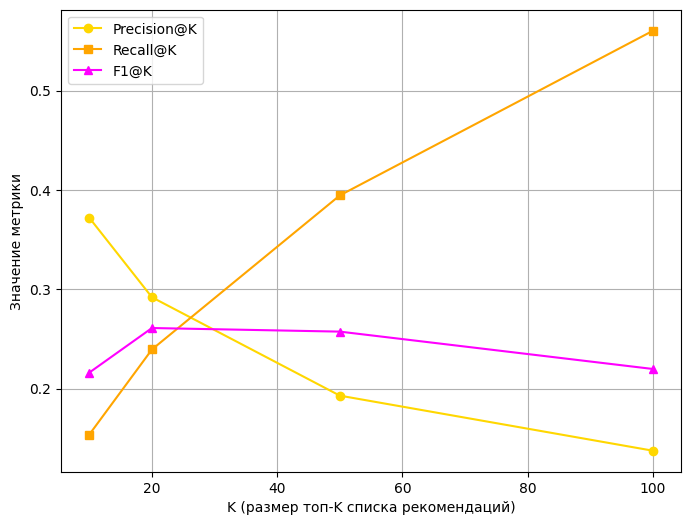

In [67]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from implicit.als import AlternatingLeastSquares
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm

# Параметры синтетики
n_users = 1000    # кол-во пользователей
n_jobs  = 500     # кол-во вакансий
density = 0.05    # увеличьте до 5%

# Фиксируем seed для воспроизводимости
rng = np.random.default_rng(42)

# Создаём булеву матрицу откликов и преобразуем в float
mask = rng.random((n_users, n_jobs)) < density
interaction_matrix = sparse.csr_matrix(mask.astype(float))

print("Сгенерировано взаимодействий:", interaction_matrix.nnz)

# 80% пользователей — для обучения, 20% — для теста
all_users = np.arange(n_users)
train_users, test_users = train_test_split(all_users, test_size=0.2, random_state=42)

# Собираем train_matrix (user×job) по train_users
train_mask = np.zeros(n_users, bool)
train_mask[train_users] = True
train_matrix = interaction_matrix[train_mask]  # shape=(len(train_users), n_jobs)

print("train_matrix.shape:", train_matrix.shape)

# Обучение ALS
model = AlternatingLeastSquares(
    factors=50,  # увеличьте до 50
    regularization=0.01,  # уменьшите до 0.01
    iterations=30,  # увеличьте до 30
    use_gpu=False
)

model.fit(train_matrix.T)
print("Обучение завершено.")

# Для каждого test_user собираем множество реальных вакансий
true_interactions = {}
for u in test_users:
    idx = u  # индекс пользователя в полной матрице
    nz = interaction_matrix[idx].nonzero()[1]
    true_interactions[u] = set(nz)

print("Пользователей в оценке:", len(true_interactions))

# Оценка Precision/Recall/F1 для разных K
Ks = [10, 20, 50, 100]
precisions, recalls, f1s = [], [], []

for K in Ks:
    p_list, r_list, f_list = [], [], []
    for u in true_interactions.keys():
        user_interactions = interaction_matrix[u]
        rec_ids, _ = model.recommend(u, user_interactions, N=K, recalculate_user=True, filter_already_liked_items=False)
        rec_set = set(rec_ids)
        true_set = true_interactions[u]

        tp = len(rec_set & true_set)
        fp = len(rec_set - true_set)
        fn = len(true_set - rec_set)

        p = tp/(tp+fp) if (tp+fp) else 0
        r = tp/(tp+fn) if (tp+fn) else 0
        f = 2*p*r/(p+r) if (p+r) else 0

        p_list.append(p)
        r_list.append(r)
        f_list.append(f)

    precisions.append(np.mean(p_list))
    recalls.append(np.mean(r_list))
    f1s.append(np.mean(f_list))

print("Precision@K:", precisions)
print("Recall@K:   ", recalls)
print("F1@K:       ", f1s)

# Визуализация
plt.figure(figsize=(8, 6))
plt.plot(Ks, precisions, 'o-', label='Precision@K', color='gold')
plt.plot(Ks, recalls, 's-', label='Recall@K', color='orange')
plt.plot(Ks, f1s, '^-', label='F1@K', color='magenta')
plt.xlabel('K (размер топ-K списка рекомендаций)')
plt.ylabel('Значение метрики')
plt.legend()
plt.grid(True)
plt.show()